# Data Extraction

## some basic indexing of the raw locust logs

In [26]:
import glob, re
from collections import OrderedDict
statsfiles = sorted(glob.glob("data/*.stats.log"))
testruns = []
for statsfile in statsfiles:
    m = re.search('/*([0-9]+)workers-([0-9]+)clients-i-[^-]*(-.*)?\..*\.log', statsfile)
    workers, clients = m.group(1, 2)
    note = ''
    try:
        note = m.group(3)[1:]
    except:
        pass
    eventsfile = re.sub('\.stats\.log', '.events.log', statsfile)
    testruns.append(OrderedDict({
            'note': note,
            'workers': int(workers),
            'clients': int(clients),
            'statsfile': statsfile,
            'eventsfile': eventsfile,
        }))

In [27]:
print('indexed {} test runs'.format(len(testruns)))

indexed 56 test runs


## extract timestamps of citical points for each test run

In [28]:
for run in testruns:
    ts_hatching_start = None
    ts_hatching_finish = None
    ts_done = None
    with open(run['eventsfile']) as events:
        for line in events:
            if "Hatching and swarming" in line:
                ts_hatching_start = re.search('^\[(.*)\]', line).group(1)
            elif "All locusts hatched" in line:
                ts_hatching_finish = re.search('^\[(.*)\]', line).group(1)
            elif "Got SIGTERM signal" in line:
                ts_done = re.search('^\[(.*)\]', line).group(1)
    run['ts_hatching_start'] = ts_hatching_start[:-4]
    run['ts_hatching_finish'] = ts_hatching_finish[:-4]
    run['ts_done'] = ts_done[:-4]

In [29]:
from tabulate import tabulate
runs_no_files = [ OrderedDict((k, run[k]) for k in run.keys() if k not in ['eventsfile','statsfile']) for run in testruns]
print(tabulate(runs_no_files, headers='keys'))

  workers    clients  note         ts_hatching_start    ts_hatching_finish    ts_done
---------  ---------  -----------  -------------------  --------------------  -------------------
       20        275               2017-01-13 21:41:57  2017-01-13 21:42:08   2017-01-13 21:51:56
       20        330               2017-01-13 21:52:17  2017-01-13 21:52:31   2017-01-13 22:02:16
       20        385               2017-01-13 22:02:37  2017-01-13 22:02:53   2017-01-13 22:12:37
       20        440               2017-01-13 22:12:57  2017-01-13 22:13:17   2017-01-13 22:22:57
       20        495               2017-01-13 22:23:17  2017-01-13 22:23:40   2017-01-13 22:33:17
       20        550               2017-01-13 22:33:37  2017-01-13 22:34:05   2017-01-13 22:43:37
       20        688               2017-01-13 22:43:57  2017-01-13 22:44:34   2017-01-13 22:53:57
       20        825               2017-01-13 22:54:17  2017-01-13 22:55:16   2017-01-13 23:04:17
       28        175  two_course

## extract throughput from locust's perspective (requests per second)

In [30]:
for run in testruns:
    with open(run['statsfile']) as events:
        lines = events.readlines()
    rps = next(l for l in reversed(lines) if ' Total' in l).split()[-1]
    run['stat_rps'] = float(rps)

In [31]:
for run in testruns:
    with open(run['statsfile']) as events:
        lines = events.readlines()
    times = next(l for l in reversed(lines) if ' GET courseware:index' in l).split()
    time_50 = times[-9]
    time_90 = times[-5]
    run['stat_time_50'] = float(time_50)
    run['stat_time_90'] = float(time_90)

# MySQL/DMS tests (not PERF-404)

In [32]:
runs_no_files = [ OrderedDict((k, run[k]) for k in run.keys() if k not in ['eventsfile','statsfile']) for run in testruns]
baseline_workers = 28
baseline_runs=[run for run in runs_no_files
               if run['workers'] == baseline_workers and run['note'] in ['','after_sync','during_sync','mysql_5.7']]
print(tabulate(sorted(baseline_runs, key=lambda x: x['note']), headers='keys'))

  workers    clients  note         ts_hatching_start    ts_hatching_finish    ts_done                stat_rps    stat_time_50    stat_time_90
---------  ---------  -----------  -------------------  --------------------  -------------------  ----------  --------------  --------------
       28        175               2017-01-18 18:19:09  2017-01-18 18:19:16   2017-01-18 18:29:09       201.9             730            1200
       28        210               2017-01-18 18:29:29  2017-01-18 18:29:38   2017-01-18 18:39:29       246.2             870            1300
       28        245               2017-01-18 18:39:49  2017-01-18 18:40:00   2017-01-18 18:49:49       275.5            1000            1500
       28        280               2017-01-18 18:50:09  2017-01-18 18:50:22   2017-01-18 19:00:09       288.6            1100            1600
       28        315               2017-01-18 19:00:29  2017-01-18 19:00:44   2017-01-18 19:10:29       322.3            1300            1700
      

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

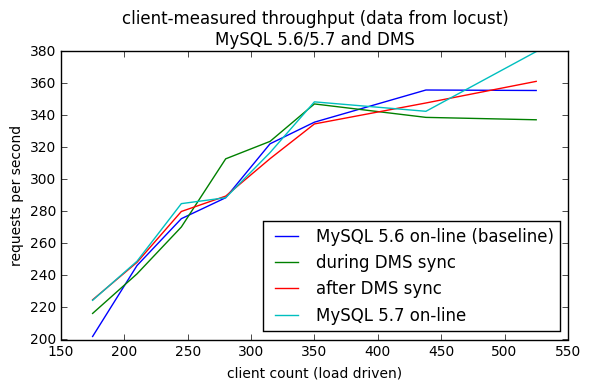

In [34]:
baseline_runs = [run for run in testruns if run['workers'] == 28 and run['note'] == '']
during_sync_runs = [run for run in testruns if run['workers'] == 28 and run['note'] == 'during_sync']
after_sync_runs = [run for run in testruns if run['workers'] == 28 and run['note'] == 'after_sync']
mysql_new_runs = [run for run in testruns if run['workers'] == 28 and run['note'] == 'mysql_5.7']

fig = plt.figure()

plt.title('client-measured throughput (data from locust)\nMySQL 5.6/5.7 and DMS')
plt.xlabel('client count (load driven)')
plt.ylabel('requests per second')

baseline_line, = plt.plot(np.array([float(run['clients']) for run in baseline_runs]),
                          np.array([run['stat_rps'] for run in baseline_runs]))
during_sync_line, = plt.plot(np.array([float(run['clients']) for run in during_sync_runs]),
                             np.array([run['stat_rps'] for run in during_sync_runs]))
after_sync_line, = plt.plot(np.array([float(run['clients']) for run in after_sync_runs]),
                            np.array([run['stat_rps'] for run in after_sync_runs]))
mysql_new_line, = plt.plot(np.array([float(run['clients']) for run in mysql_new_runs]),
                           np.array([run['stat_rps'] for run in mysql_new_runs]))


plt.legend((baseline_line, during_sync_line, after_sync_line, mysql_new_line), 
           ('MySQL 5.6 on-line (baseline)', 'during DMS sync', 'after DMS sync', 'MySQL 5.7 on-line'),
           loc='lower right')

fig.tight_layout()  # needed for a quirk in jupyter/matplotlib integration.
plt.savefig('results/client-measured-throughput_mysql5.6_dms_mysql5.7.png')

# Tuning gunicorn worker count (PERF-404)

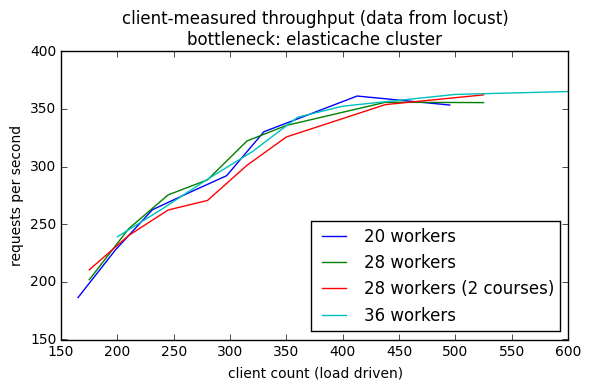

In [35]:
runs_20workers = [run for run in testruns if run['workers'] == 20]
runs_28workers = [run for run in testruns if run['workers'] == 28 and run['note'] == '']
runs_28workers_2courses = [run for run in testruns if run['workers'] == 28 and run['note'] == 'two_courses']
runs_36workers = [run for run in testruns if run['workers'] == 36]

fig = plt.figure()

C = 0.6  # this is a constant multiplier for the 20-workers test runs which used a longer wait time

line_20workers, = plt.plot(np.array([C * float(run['clients']) for run in runs_20workers]),
                           np.array([run['stat_rps'] for run in runs_20workers]))
line_28workers, = plt.plot(np.array([float(run['clients']) for run in runs_28workers]),
                           np.array([run['stat_rps'] for run in runs_28workers]))
line_28workers_2courses, = plt.plot(np.array([float(run['clients']) for run in runs_28workers_2courses]),
                                    np.array([run['stat_rps'] for run in runs_28workers_2courses]))
line_36workers, = plt.plot(np.array([float(run['clients']) for run in runs_36workers]),
                           np.array([run['stat_rps'] for run in runs_36workers]))

plt.legend((line_20workers, line_28workers, line_28workers_2courses, line_36workers), 
           ('20 workers', '28 workers', '28 workers (2 courses)', '36 workers'),
           loc='lower right')

plt.xlabel('client count (load driven)')
plt.ylabel('requests per second')
plt.title('client-measured throughput (data from locust)\nbottleneck: elasticache cluster')

fig.tight_layout()  # needed for a quirk in jupyter/matplotlib integration.
plt.savefig('results/client-measured-throughput_changing-workers_slow-elasticache.png')

In the above graph, all gunicorn worker counts resulted in the same peak throughput, but edxapp instances were still not exhausting either CPU or memory.  We discovered that one instance in the Elasticache cluster was under disproportionately high load compared to the rest, and estimated that its network throughput during the loadtest was at or above what AWS claims it can sustain (instance type in question was cache.m1.large).

In an attempt to improve cache key distribution, we tried running the load test against two courses at the same time (see the test run labeled "2 coureses").  This did improve cache key distribution across the two elasticache instances, but did not appear to affect the behavior of the 

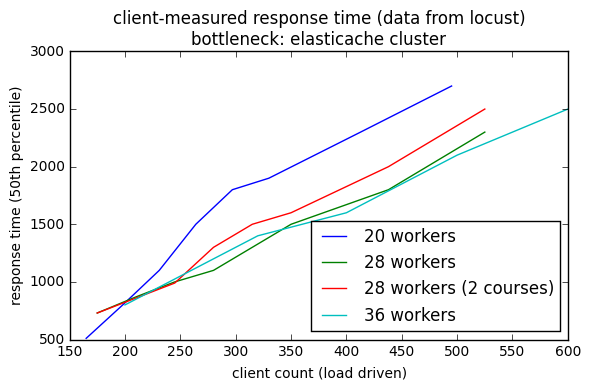

In [36]:
runs_20workers = [run for run in testruns if run['workers'] == 20]
runs_28workers = [run for run in testruns if run['workers'] == 28 and run['note'] == '']
runs_28workers_2courses = [run for run in testruns if run['workers'] == 28 and run['note'] == 'two_courses']
runs_36workers = [run for run in testruns if run['workers'] == 36]

fig = plt.figure()

C = 0.6  # this is a constant multiplier for the 20-workers test runs which used a longer wait time

line_20workers, = plt.plot(np.array([C * float(run['clients']) for run in runs_20workers]),
                           np.array([run['stat_time_50'] for run in runs_20workers]))
line_28workers, = plt.plot(np.array([float(run['clients']) for run in runs_28workers]),
                           np.array([run['stat_time_50'] for run in runs_28workers]))
line_28workers_2courses, = plt.plot(np.array([float(run['clients']) for run in runs_28workers_2courses]),
                                    np.array([run['stat_time_50'] for run in runs_28workers_2courses]))
line_36workers, = plt.plot(np.array([float(run['clients']) for run in runs_36workers]),
                           np.array([run['stat_time_50'] for run in runs_36workers]))

plt.legend((line_20workers, line_28workers, line_28workers_2courses, line_36workers), 
           ('20 workers', '28 workers', '28 workers (2 courses)', '36 workers'),
           loc='lower right')

plt.xlabel('client count (load driven)')
plt.ylabel('response time (50th percentile)')
plt.title('client-measured response time (data from locust)\nbottleneck: elasticache cluster')

fig.tight_layout()  # needed for a quirk in jupyter/matplotlib integration.
plt.savefig('results/client-measured-response-time_changing-workers_slow-elasticache.png')